# Steps to Filter Data for Ethiopia and Merge with Brent Oil Prices
Load and Explore Economic Indicators

Start by loading and exploring the GDP Growth Rates data. We will then proceed with other indicators like Inflation Rates and Interest Rates.

In [2]:
import pandas as pd

# Load GDP Growth Rates
gdp_growth = pd.read_csv('../data_collected/Economic Indicators/GDP Growth Rates/API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_261404.csv', skiprows=4)
print(gdp_growth.head())

# Load Inflation Rates
inflation_rates = pd.read_csv('../data_collected/Economic Indicators/Inflation Rates/API_FP.CPI.TOTL_DS2_en_csv_v2_269369.csv', skiprows=4)
print(inflation_rates.head())

# Load Interest Rates
interest_rates = pd.read_csv('../data_collected/Economic Indicators/Interest Rates/API_FR.INR.RINR_DS2_en_csv_v2_262777.csv', skiprows=4)
print(interest_rates.head())

                  Country Name Country Code         Indicator Name  \
0                        Aruba          ABW  GDP growth (annual %)   
1  Africa Eastern and Southern          AFE  GDP growth (annual %)   
2                  Afghanistan          AFG  GDP growth (annual %)   
3   Africa Western and Central          AFW  GDP growth (annual %)   
4                       Angola          AGO  GDP growth (annual %)   

      Indicator Code  1960      1961      1962      1963      1964      1965  \
0  NY.GDP.MKTP.KD.ZG   NaN       NaN       NaN       NaN       NaN       NaN   
1  NY.GDP.MKTP.KD.ZG   NaN  0.460106  7.868013  5.616400  4.668135  5.138990   
2  NY.GDP.MKTP.KD.ZG   NaN       NaN       NaN       NaN       NaN       NaN   
3  NY.GDP.MKTP.KD.ZG   NaN  1.873455  3.707643  7.145784  5.406403  4.102491   
4  NY.GDP.MKTP.KD.ZG   NaN       NaN       NaN       NaN       NaN       NaN   

   ...      2015      2016      2017      2018      2019       2020  \
0  ... -0.623626  1.719625 

## Preprocess the Data

Clean and prepare the economic indicators data for analysis, focusing on Ethiopia.

In [10]:
import pandas as pd

# Function to preprocess the data
def preprocess_economic_data(file_path, country, data_type):
    # Load the dataset
    df = pd.read_csv(file_path, skiprows=4)
    
    # Filter for the specific country
    df = df[df['Country Name'] == country]
    
    # Drop unnecessary columns
    df = df.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])
    
    # Remove columns with names that are not numeric (e.g., "Unnamed: 68")
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    # Melt the dataframe
    df = df.melt(id_vars=['Country Name'], var_name='Year', value_name='Value')
    
    # Convert 'Year' to numeric, forcing errors to NaN, then drop NaNs
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df = df.dropna(subset=['Year'])
    
    # Pivot the dataframe
    df = df.pivot(index='Year', columns='Country Name', values='Value')
    
    # Drop columns with all NaN values
    df = df.dropna(axis=0, how='all')
    
    # Debug print to identify the data type and show the DataFrame
    print(f"DataFrame after preprocessing ({data_type}):")
    print(df.head())
    
    return df

# File paths
gdp_growth_path = '../data_collected/Economic Indicators/GDP Growth Rates/API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_261404.csv'
inflation_rates_path = '../data_collected/Economic Indicators/Inflation Rates/API_FP.CPI.TOTL_DS2_en_csv_v2_269369.csv'
interest_rates_path = '../data_collected/Economic Indicators/Interest Rates/API_FR.INR.RINR_DS2_en_csv_v2_262777.csv'

# Preprocess each dataset for Ethiopia
country = 'Ethiopia'
gdp_growth_clean = preprocess_economic_data(gdp_growth_path, country, 'GDP Growth Rates')
inflation_rates_clean = preprocess_economic_data(inflation_rates_path, country, 'Inflation Rates')
interest_rates_clean = preprocess_economic_data(interest_rates_path, country, 'Interest Rates')

# Display the cleaned data
print("GDP Growth Rates (Ethiopia):")
print(gdp_growth_clean.head())

print("\nInflation Rates (Ethiopia):")
print(inflation_rates_clean.head())

print("\nInterest Rates (Ethiopia):")
print(interest_rates_clean.head())

DataFrame after preprocessing (GDP Growth Rates):
Country Name  Ethiopia
Year                  
1962          4.326091
1963          4.518634
1964          4.090486
1965          5.771932
1966          7.256598
DataFrame after preprocessing (Inflation Rates):
Country Name  Ethiopia
Year                  
1965          4.697902
1966          4.633923
1967          4.671396
1968          4.679927
1969          4.746648
DataFrame after preprocessing (Interest Rates):
Country Name   Ethiopia
Year                   
1985         -17.670657
1986          13.220281
1987          12.909487
1988           2.807315
1989           0.393303
GDP Growth Rates (Ethiopia):
Country Name  Ethiopia
Year                  
1962          4.326091
1963          4.518634
1964          4.090486
1965          5.771932
1966          7.256598

Inflation Rates (Ethiopia):
Country Name  Ethiopia
Year                  
1965          4.697902
1966          4.633923
1967          4.671396
1968          4.679927
1969  

## Merge Economic Indicators with Brent Oil Prices

Combine the Brent oil prices data with the cleaned economic indicators for Ethiopia.

In [15]:
import pandas as pd

# Function to preprocess the data
def preprocess_economic_data(file_path, country, data_type):
    # Load the dataset
    df = pd.read_csv(file_path, skiprows=4)
    
    # Filter for the specific country
    df = df[df['Country Name'] == country]
    
    # Drop unnecessary columns
    df = df.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])
    
    # Remove columns with names that are not numeric (e.g., "Unnamed: 68")
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    # Melt the dataframe to long format
    df = df.melt(id_vars=['Country Name'], var_name='Year', value_name='Value')
    
    # Convert 'Year' to numeric, forcing errors to NaN, then drop NaNs
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df = df.dropna(subset=['Year'])
    
    # Pivot the dataframe to have 'Year' as index and values for each country
    df = df.pivot(index='Year', columns='Country Name', values='Value')
    
    # Drop rows with all NaN values
    df = df.dropna(axis=0, how='all')
    
    # Debug print to identify the data type and show the DataFrame
    print(f"DataFrame after preprocessing ({data_type}):")
    print(df.head())
    
    return df

# File paths
gdp_growth_path = '../data_collected/Economic Indicators/GDP Growth Rates/API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_261404.csv'
inflation_rates_path = '../data_collected/Economic Indicators/Inflation Rates/API_FP.CPI.TOTL_DS2_en_csv_v2_269369.csv'
interest_rates_path = '../data_collected/Economic Indicators/Interest Rates/API_FR.INR.RINR_DS2_en_csv_v2_262777.csv'
brent_oil_prices_path = '../data/processed/cleaned_data_with_features.csv'  # Updated path

# Preprocess each dataset for Ethiopia
country = 'Ethiopia'
gdp_growth_clean = preprocess_economic_data(gdp_growth_path, country, 'GDP Growth Rates')
inflation_rates_clean = preprocess_economic_data(inflation_rates_path, country, 'Inflation Rates')
interest_rates_clean = preprocess_economic_data(interest_rates_path, country, 'Interest Rates')

# Load Brent oil prices data
brent_oil_prices = pd.read_csv(brent_oil_prices_path)

# Print the column names to check for 'Date'
print("Column names in Brent oil prices data:", brent_oil_prices.columns)

# Strip leading and trailing spaces from column names
brent_oil_prices.columns = brent_oil_prices.columns.str.strip()

# Extract 'Year' from 'Date' column
brent_oil_prices['Date'] = pd.to_datetime(brent_oil_prices['Date'], errors='coerce')
brent_oil_prices['Year'] = brent_oil_prices['Date'].dt.year

# Drop rows with NaNs in 'Year'
brent_oil_prices = brent_oil_prices.dropna(subset=['Year'])

# Convert 'Year' to integer
brent_oil_prices['Year'] = brent_oil_prices['Year'].astype(int)

# Print the first few rows to verify 'Year' extraction
print("Brent oil prices data with 'Year':")
print(brent_oil_prices.head())

# Merge datasets
merged_data = brent_oil_prices.merge(gdp_growth_clean, on='Year', how='left', suffixes=('', '_GDP'))
merged_data = merged_data.merge(inflation_rates_clean, on='Year', how='left', suffixes=('', '_Inflation'))
merged_data = merged_data.merge(interest_rates_clean, on='Year', how='left', suffixes=('', '_Interest'))

# Display the merged data
print("Merged Data:")
print(merged_data.head())

# Save the merged data to a CSV file for further analysis
merged_data.to_csv('../data/merged_data/merged_brent_oil_prices_with_economic_indicators.csv', index=False)

DataFrame after preprocessing (GDP Growth Rates):
Country Name  Ethiopia
Year                  
1962          4.326091
1963          4.518634
1964          4.090486
1965          5.771932
1966          7.256598
DataFrame after preprocessing (Inflation Rates):
Country Name  Ethiopia
Year                  
1965          4.697902
1966          4.633923
1967          4.671396
1968          4.679927
1969          4.746648
DataFrame after preprocessing (Interest Rates):
Country Name   Ethiopia
Year                   
1985         -17.670657
1986          13.220281
1987          12.909487
1988           2.807315
1989           0.393303
Column names in Brent oil prices data: Index(['Date', 'Price', 'Price_MA30', 'Price_MA90', 'Price_Rolling_STD30',
       'Price_Rolling_STD90', 'Price_Lag1', 'Price_Lag7', 'Price_Lag30'],
      dtype='object')
Brent oil prices data with 'Year':
        Date  Price  Price_MA30  Price_MA90  Price_Rolling_STD30  \
0 1987-09-23  18.48   18.312333   18.999556       

## Advanced Time Series Modeling

Implement advanced time series models such as VAR, Markov-Switching ARIMA, and LSTM.

### Vector Autoregression (VAR)

ADF Statistic: -2.1788143519444465
p-value: 0.21402427271193486
ADF Statistic: -9.528714698566862
p-value: 2.929924623516545e-16
ADF Statistic: -2.9724382561290077
p-value: 0.03754972364671737
ADF Statistic: 1.113735627956446
p-value: 0.9953321624118419
ADF Statistic: -73.5941063547144
p-value: 0.0
ADF Statistic: -1.7935196044955075
p-value: 0.38368374343974615
ADF Statistic: -73.53391994337957
p-value: 0.0
Column: Price
ADF Statistic: -9.528714698566862
p-value: 2.929924623516545e-16
Column: Ethiopia
ADF Statistic: -2.9724382561290077
p-value: 0.03754972364671737
Column: Ethiopia_Inflation
ADF Statistic: -73.5941063547144
p-value: 0.0
Column: Ethiopia_Interest
ADF Statistic: -73.53391994337957
p-value: 0.0


d:\brent-oil-analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -2.626      -2.620     0.07238      -2.624
1      -7.658*     -7.628*  0.0004724*     -7.647*
2       -7.652      -7.599   0.0004751      -7.633
3       -7.648      -7.571   0.0004772      -7.620
4       -7.642      -7.541   0.0004798      -7.607
5       -7.638      -7.514   0.0004818      -7.594
6       -7.640      -7.491   0.0004810      -7.587
7       -7.634      -7.462   0.0004838      -7.573
8       -7.633      -7.437   0.0004843      -7.564
9       -7.627      -7.407   0.0004873      -7.549
10      -7.623      -7.380   0.0004891      -7.537
11      -7.639      -7.372   0.0004814      -7.545
12      -7.635      -7.345   0.0004832      -7.533
13      -7.628      -7.314   0.0004864      -7.518
14      -7.623      -7.286   0.0004888      -7.504
15      -7.619      -7.257   0.0004913      -7.491
16      -7.613      -7.228   0.

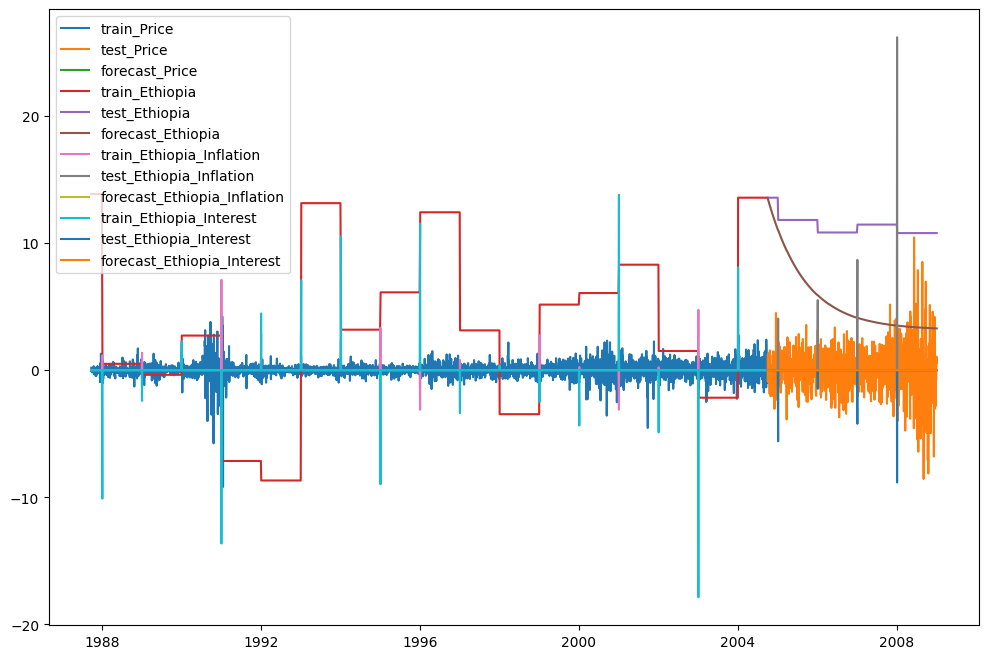

In [18]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Load the merged data
merged_data_path = '../data/merged_data/merged_brent_oil_prices_with_economic_indicators.csv'
data = pd.read_csv(merged_data_path)

# Ensure the data is in a proper format (drop NaNs, set index)
data = data.dropna()
data.set_index('Date', inplace=True)

# Convert index to datetime
data.index = pd.to_datetime(data.index)

# Select relevant columns for VAR model
columns_of_interest = ['Price', 'Ethiopia', 'Ethiopia_Inflation', 'Ethiopia_Interest']
data = data[columns_of_interest]

# Check stationarity and difference if necessary
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())  # Ensure no NaNs are in the series
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    return result[1] <= 0.05  # Returns True if series is stationary

# Differencing non-stationary series until stationary
def make_stationary(df):
    for column in df.columns:
        diff_count = 0
        while not check_stationarity(df[column]):
            df[column] = df[column].diff().dropna()
            diff_count += 1
            if diff_count > 2:  # Prevent infinite loop, max 2 differences
                print(f"{column} required more than 2 differencing steps to become stationary.")
                break
    return df

data_stationary = make_stationary(data.copy())

# Recheck stationarity
for column in data_stationary.columns:
    print(f"Column: {column}")
    check_stationarity(data_stationary[column])

# Add a date range frequency
data_stationary = data_stationary.asfreq('D').dropna()

# Train-test split
train_size = int(len(data_stationary) * 0.8)
train, test = data_stationary[:train_size], data_stationary[train_size:]

# Fit the VAR model
model = VAR(train)
lag_order = model.select_order()
print(lag_order.summary())
model_fitted = model.fit(lag_order.aic)

# Check for serial correlation of residuals
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)
for col, val in zip(data_stationary.columns, out):
    print(f"{col} : {val:.3f}")

# Forecasting
lagged_values = train.values[-lag_order.aic:]
forecast_input = lagged_values[-lag_order.aic:]
forecast = model_fitted.forecast(y=forecast_input, steps=len(test))

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast, index=test.index, columns=test.columns)

# Plot the results
plt.figure(figsize=(12, 8))
for col in data_stationary.columns:
    plt.plot(train.index, train[col], label=f'train_{col}')
    plt.plot(test.index, test[col], label=f'test_{col}')
    plt.plot(forecast_df.index, forecast_df[col], label=f'forecast_{col}')
plt.legend()
plt.show()

### Markov-Switching ARIMA

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm

# Load the merged data
merged_data_path = '../data/merged_data/merged_brent_oil_prices_with_economic_indicators.csv'
data = pd.read_csv(merged_data_path)

# Ensure the data is in a proper format (drop NaNs, set index)
data = data.dropna()
data.set_index('Date', inplace=True)

# Convert index to datetime
data.index = pd.to_datetime(data.index)

# Select relevant column for MS-ARIMA model
column_of_interest = 'Price'
series = data[column_of_interest]

# Fit the MS-ARIMA model
# Here we consider an ARIMA model with regimes
model = pm.auto_arima(series, seasonal=False, stepwise=True,
                      suppress_warnings=True, error_action='ignore',
                      max_p=3, max_q=3, trace=True)

# Summary of the fitted model
print(model.summary())

# Plot diagnostics
model.plot_diagnostics(figsize=(10, 6))
plt.show()

# Forecasting
n_periods = 10
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
print(f"Forecast: {forecast}")
print(f"Confidence Intervals: {conf_int}")

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(series, label='Historical Data')
plt.plot(pd.date_range(start=series.index[-1], periods=n_periods, freq='B'), forecast, label='Forecast')
plt.fill_between(pd.date_range(start=series.index[-1], periods=n_periods, freq='B'), 
                 conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.1)
plt.legend()
plt.show()

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## LSTM (Long Short-Term Memory)

In [27]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

ModuleNotFoundError: No module named 'distutils'